# Try the SimImage dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
# added 11.05，today I know that python's convention is lowercase letters, but that's not what happened in my code here. 
import os
from lxml import etree
from detectron2.structures import BoxMode

def getSimimageDicts(imgDir):
    xmlFiles=os.listdir(os.path.join(imgDir,'Annotations'))
    dataset_dicts=[]
    for file in xmlFiles:
        record={}
        tree=etree.parse(os.path.join(imgDir,'Annotations',file))
        root=tree.getroot()
        tags=[]
        texts=[]
        bboxes=[]
        for c in root.iter():
            tags.append(c.tag)
            texts.append(c.text)
            if c.tag=='bndbox':
                bboxes.append(c)
        record['file_name']=os.path.join(imgDir,texts[tags.index('filename')])
        record['width']=int(texts[tags.index('width')])
        record['height']=int(texts[tags.index('height')])
        objs=[]
        for bbox in bboxes:
            box=[]
            for b in bbox.iterchildren():
                box.append(int(b.text))
            obj={
                'bbox':box,
                'bbox_mode':BoxMode.XYXY_ABS,
                'category_id':0,
                'iscrowd':0
            }
            objs.append(obj)
        record['annotations']=objs
        dataset_dicts.append(record)
    return dataset_dicts

In [3]:
getSimimageDicts('simImage/val/')

[{'annotations': [{'bbox': [52, 188, 71, 223],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0,
    'iscrowd': 0}],
  'file_name': 'simImage/val/145-1.jpg',
  'height': 380,
  'width': 190},
 {'annotations': [{'bbox': [62, 252, 85, 293],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0,
    'iscrowd': 0}],
  'file_name': 'simImage/val/162-1.jpg',
  'height': 380,
  'width': 190},
 {'annotations': [{'bbox': [59, 253, 86, 300],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0,
    'iscrowd': 0}],
  'file_name': 'simImage/val/156-1.jpg',
  'height': 380,
  'width': 190},
 {'annotations': [{'bbox': [67, 198, 88, 239],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0,
    'iscrowd': 0}],
  'file_name': 'simImage/val/141-1.jpg',
  'height': 380,
  'width': 190},
 {'annotations': [{'bbox': [106, 239, 130, 273],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0,
    'iscrowd': 0}],
  'file_name': 'simImage/val/135.jpg',
  'height': 38

In [4]:
from detectron2.data import DatasetCatalog, MetadataCatalog

In [5]:
for d in ['train','val']:
    DatasetCatalog.register('simImage/'+d, lambda d = d: getSimimageDicts('simImage/'+d))
    MetadataCatalog.get('simImage/'+d).set(thing_classes=['object'])
object_metadata=MetadataCatalog.get('simImage/train')

In [6]:
import random
from detectron2.utils.visualizer import Visualizer
from matplotlib import pyplot as plt
import numpy as np

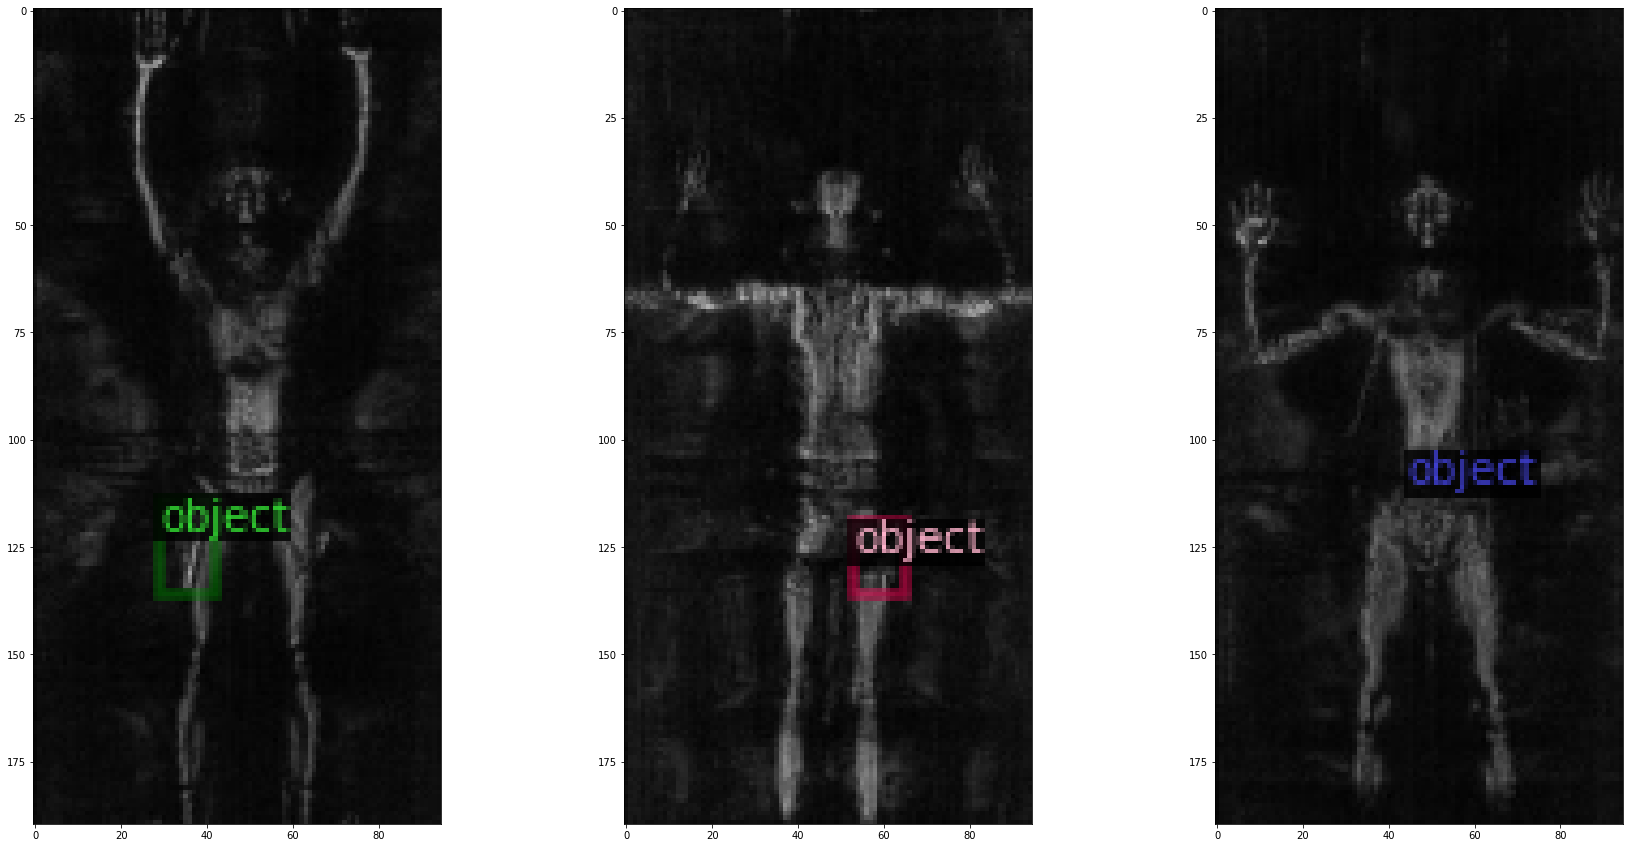

In [7]:
dataset_dicts=getSimimageDicts('simImage/val')
plt.figure(figsize=(30,15))
i=1
for d in random.sample(dataset_dicts,3):
    img=plt.imread(d['file_name'])
    visualizer = Visualizer(img[:,:,::-1],metadata=object_metadata,scale=0.5)
    vis=visualizer.draw_dataset_dict(d)
    plt.subplot(1,3,i)
    i+=1
    plt.imshow(vis.get_image()[:,:,::-1])
        

In [43]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file('../configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml')
cfg.DATASETS.TRAIN = ('simImage/train',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = '../models/model_final_280758.pkl'  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Config '../configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


OrderedDict()

In [44]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS=os.path.join(cfg.OUTPUT_DIR,'model_final.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST=0.7
cfg.DATASETS.TEST=('simImage/val')
predictor = DefaultPredictor(cfg)

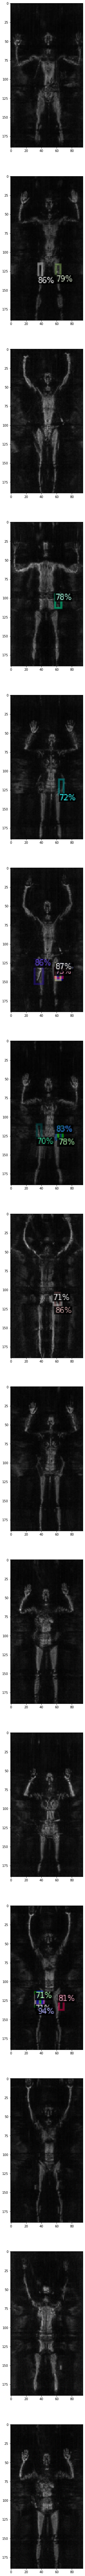

In [45]:
from detectron2.utils.visualizer import ColorMode
from matplotlib import pyplot as plt

dataset_dicts = getSimimageDicts('simImage/val')
i=1
plt.figure(figsize=(30,150))
for d in random.sample(dataset_dicts, 15):
    im = plt.imread(d['file_name'])
#     im = cv2.imread(d['file_name'])
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1],
                   metadata=object_metadata,
                   scale=0.5,
#                    instance_mode=ColorMode.IMAGE_BW # remove the color of unsegmented pixels
    )
#     print(outputs)
    v = v.draw_instance_predictions(outputs['instances'].to('cpu'))
    plt.subplot(15,1,i)
    i+=1
    plt.imshow(v.get_image()[:,:,::-1])